Dataset: https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
data ='https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [ ]:
!wget $data -O homework.csv 

In [5]:
df = pd.read_csv('homework.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [6]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [7]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [8]:
#Split categorical and numerical features
categorical = ['lead_source','industry','employment_status','location']
numerical = ['number_of_courses_viewed','annual_income','interaction_count','lead_score']

In [9]:
#Filling Missing Vales
for col in categorical:
    df[col] = df[col].fillna('NA')
for col in numerical:
    df[col] = df[col].fillna(0.0)

In [10]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

### Validation Framework

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [12]:
len(df_full_train), len(df_train), len(df_val), len(df_test), len(df)

(1169, 876, 293, 293, 1462)

### ROC AUC Score - Feature Importance

In [13]:
from sklearn.metrics import roc_auc_score

In [14]:
for col in numerical:
    auc = roc_auc_score(y_train, df_train[col])
    if auc<0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    print('%s = %.3f' % (col, auc))

number_of_courses_viewed = 0.764
annual_income = 0.552
interaction_count = 0.738
lead_score = 0.614


### Training the model

In [15]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [16]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [17]:
round(roc_auc_score(y_val, y_pred),3)

0.817

In [19]:
0.92 - roc_auc_score(y_val, y_pred)

0.10286837311858887

In [53]:
abs(0.72 - roc_auc_score(y_val, y_pred))

0.09713162688141119

### Precision and Recall

In [37]:
scores=[]
thresholds = np.linspace(0.0,1.0,101)
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (actual_positive & predict_positive).sum()
    tn = (actual_negative & predict_negative).sum()
    fp = (actual_negative & predict_positive).sum()
    fn = (actual_positive & predict_negative).sum()
    scores.append((t,tp,fp,fn,tn))

In [38]:
columns = ['threshold','tp','fp','fn','tn']
df_scores = pd.DataFrame(scores,columns = columns)

In [39]:
df_scores['precision'] = df_scores.tp / (df_scores.tp+df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp+df_scores.fn)

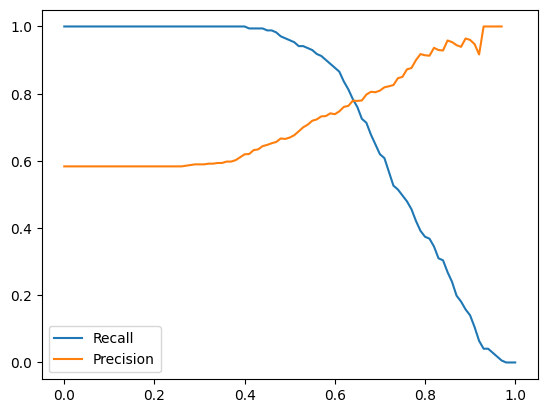

In [40]:
plt.plot(df_scores.threshold,df_scores.recall,label = 'Recall')
plt.plot(df_scores.threshold,df_scores.precision,label = 'Precision')
plt.legend()

In [49]:
df_scores['p - r'] = abs(df_scores['precision'] - df_scores['recall'])
df_scores['p - r'].min()

np.float64(0.0045559635522914865)

In [50]:
df_scores[df_scores['p - r'] == df_scores['p - r'].min()]

,threshold,tp,fp,fn,tn,precision,recall,p - r
64,0.64,134,38,37,84,0.77907,0.783626,0.004556


In [51]:
abs(0.545 - 0.64)

0.09499999999999997

In [52]:
abs(0.745 - 0.64)

0.10499999999999998

### F1 Score

In [54]:
df_scores['F1'] = 2*((df_scores['precision'] * df_scores['recall']) / (df_scores['precision'] + df_scores['recall']))

In [55]:
df_scores[df_scores['F1'] == df_scores['F1'].max()]

,threshold,tp,fp,fn,tn,precision,recall,p - r,F1
57,0.57,156,57,15,65,0.732394,0.912281,0.179886,0.8125


### 5-Fold CV

In [64]:
from sklearn.model_selection import KFold

In [85]:
def train(df_train,y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient = 'records')

    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train,y_train)

    return dv, model

In [86]:
def predict (df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient = 'records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [87]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.converted.values
    y_val = df_val.converted.values
    
    dv, model = train(df_train,y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
        
print('Scores = ',scores)
print('Std Dev = %.4f' %(np.std(scores)))

Scores =  [0.8060745924216483, 0.8713738368910783, 0.7754320118852139, 0.8018368617683685, 0.8558272713202291]
Std Dev = 0.0358


In [88]:
abs(np.std(scores) - 0.06)

np.float64(0.02419288057094835)

In [89]:
abs(np.std(scores) - 0.006)

np.float64(0.02980711942905165)

### Hyperparameter Tuning

In [90]:
from tqdm.auto import tqdm

In [93]:
for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.converted.values
        y_val = df_val.converted.values
        
        dv, model = train(df_train,y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +/- %.3f'% (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.560 +/- 0.024
C=0.001 0.867 +/- 0.029
C=1 0.822 +/- 0.036
